# Perkenalan

Nama : Jason Rich Darmawan Onggo Putra

Batch : 016 RMT

Data set overview :

Objective : 

# Import Libraries

In [1]:
# kaggle use tensorflow==2.6.4
# Apple M1 Silicion can't use tensorflow==2.6.4
# !pip install -U tensorflow-gpu==2.10.0

In [2]:
# Data Loading
import os
import glob
import pandas as pd

# EDA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image

# Data Preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
import numpy as np

import tensorflow as tf
print('Tensorflow version', tf.__version__)


Tensorflow version 2.6.4


# Data Loading

In [3]:
# Download the data set
# !kaggle datasets download chrisfilo/fruit-recognition

In [4]:
# Unzip the data set
# -q = quiet mode
# -n never overwrite existing files
# -o overwrite fies WITHOUT prompting
# -d exdir
# !unzip -q -n fruit-recognition.zip -d ./data

In [5]:
# master path
master_data = '/kaggle/input/fruit-recognition'
master_result = '/kaggle/working'

In [6]:
# Get kind of fruits
print(os.listdir(master_data))

['Orange', 'Pomegranate', 'Plum', 'Apple', 'Carambola', 'Guava', 'Kiwi', 'Pear', 'Persimmon', 'Tomatoes', 'muskmelon', 'Peach', 'Banana', 'Pitaya', 'Mango']


In [7]:
# Get Apple sub-categories
# folder 'Total Number of Apples' is similar to folder '
print(os.listdir(f'{master_data}/Apple/'))

['Apple B', 'Apple C', 'Apple E', 'Total Number of Apples', 'Apple A', 'Apple D', 'Apple F']


In [8]:
# Get Apple images
print(os.listdir(f'{master_data}/Apple/Apple A')[:5])
# Get Banana images
print(os.listdir(f'{master_data}/Banana/')[:5])

['Apple 325.png', 'Apple 489.png', 'Apple 625.png', 'Apple 357.png', 'Apple 479.png']
['Banana02933.png', 'Banana0767.png', 'Banana02556.png', 'Banana0544.png', 'Banana02867.png']


In [9]:
# Get kind of fruits and its sub-categories
def print_kinds():
    kinds = os.listdir(master_data)
    print("kinds", kinds)
    for kind in kinds:
        sub_categories = [path for path in os.listdir(f'{master_data}/{kind}') 
                          if os.path.isdir(f'{master_data}/{kind}/{path}')]
        if len(sub_categories) != 0:
            print("sub-categories of", kind, sub_categories)
    
print_kinds()

kinds ['Orange', 'Pomegranate', 'Plum', 'Apple', 'Carambola', 'Guava', 'Kiwi', 'Pear', 'Persimmon', 'Tomatoes', 'muskmelon', 'Peach', 'Banana', 'Pitaya', 'Mango']
sub-categories of Apple ['Apple B', 'Apple C', 'Apple E', 'Total Number of Apples', 'Apple A', 'Apple D', 'Apple F']
sub-categories of Guava ['guava B', 'guava total final', 'guava A', 'Guava total']
sub-categories of Kiwi ['Kiwi B', 'kiwi A', 'Total Number of Kiwi fruit', 'Kiwi C']


TODO
- [ ] Do EDA on Apple, Guava, Kiwi sub-categories.

In [10]:
# Load the data set
def isolate():
    global df
    
    data = []
    
    kinds = os.listdir(master_data)
    for kind in kinds:
        sub_categories = [path for path in os.listdir(f'{master_data}/{kind}')
                          if os.path.isdir(f'{master_data}/{kind}/{path}')]
        # ./Apple/Apple A -> sub_categories = ['Apple A']
        # ./Banana/71Banana02034.png -> sub_categories = []
        for sub_category in sub_categories:
            data += [[sub_category, path] for path in 
                     glob.glob(pathname=f'{master_data}/{kind}/{sub_category}/*.png')]
            continue
        
        data += [[kind, path] for path in glob.glob(pathname=f'{master_data}/{kind}/*.png')]
            
    df = pd.DataFrame(data=data, columns=['kind', 'path'])
    
isolate()

In [11]:
# Preview the data set
df.head()

,kind,path
0,Orange,/kaggle/input/fruit-recognition/Orange/Orange0...
1,Orange,/kaggle/input/fruit-recognition/Orange/Orange0...
2,Orange,/kaggle/input/fruit-recognition/Orange/Orange0...
3,Orange,/kaggle/input/fruit-recognition/Orange/Orange0...
4,Orange,/kaggle/input/fruit-recognition/Orange/Orange0...


# Functions

In [12]:
# visualize each sub categories with 3 samples.
def imshow_kind(data=df, kind='Apple'):
    samples = data[data['kind'].str.contains(kind, case=False)] \
        .groupby(by='kind').sample(3, random_state=None)
    
    fig, axes = plt.subplots(
        nrows=len(samples['kind'].unique()), ncols=3, figsize=(10,10), 
        layout='constrained')
    for (_, sample), ax in zip(samples.iterrows(), axes.ravel()):
        img = mpimg.imread(sample['path'])
        ax.imshow(img)
        ax.set_title("/".join(sample['path'].split('/')[-2:]))

# Exploratory Data Analysis

In [13]:
# Duplicate the data set
df_a = df.copy()

## Apple sub-categories

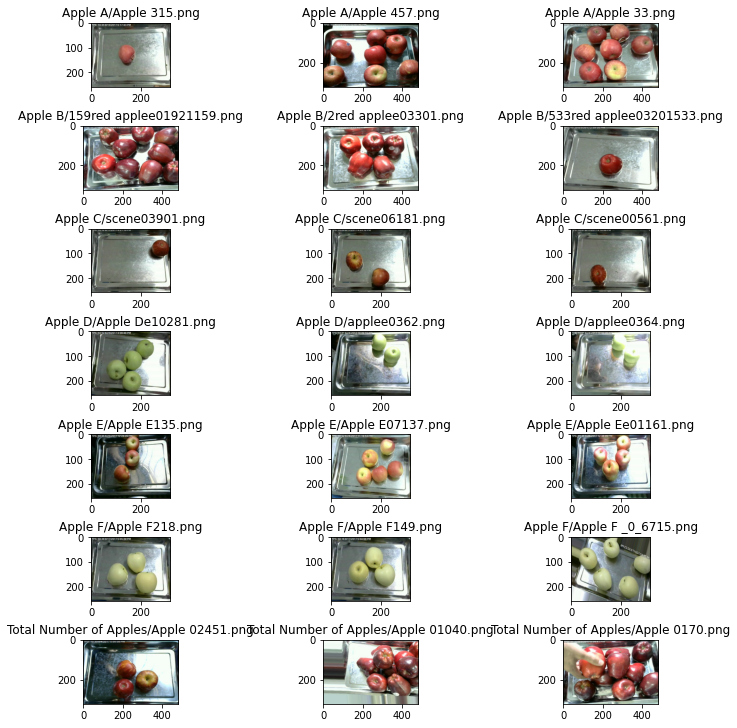

In [14]:
imshow_kind(data=df_a, kind='Apple')

IMPORTANT
- Do not use folder 'Total Number of Apples' to train

  The folder contains mutiple sub-categories of Apple.

In [15]:
# drop kind 'Total Number of Apples'
def isolate():
    indicies = df_a[df_a['kind'] == 'Total Number of Apples'].index
    df_a.drop(index=indicies, inplace=True)
    
isolate()

## Guava sub-categories

/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 12290 (\N{IDEOGRAPHIC FULL STOP}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12290 (\N{IDEOGRAPHIC FULL STOP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


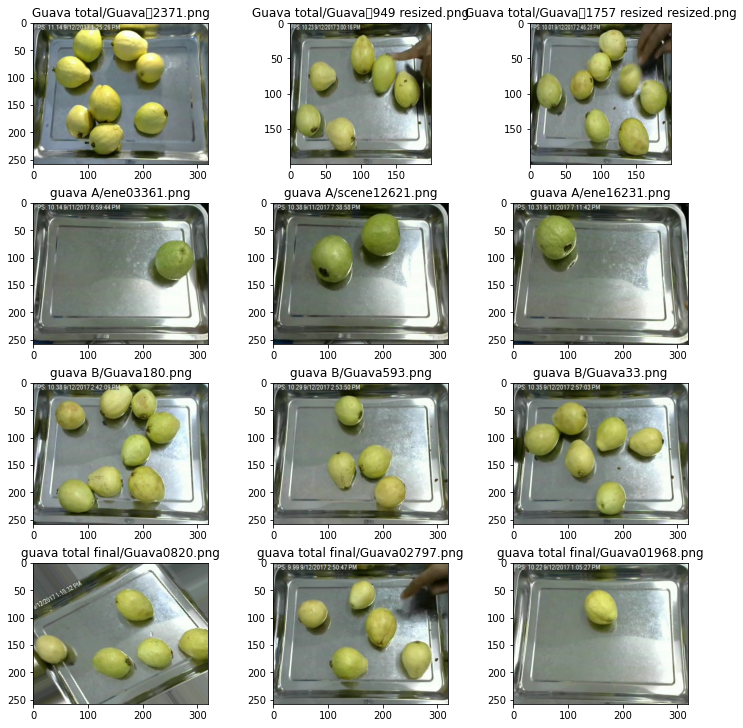

In [16]:
imshow_kind(data=df_a, kind='Guava')

IMPORTANT
- Do not use folder 'Guava total' and 'Guava total final'
  
  We can't distinguish folder 'Guava total' and 'guava total final'

In [17]:
# Drop kind 'Guava total', 'guava total final'
def isolate():
    indicies = df_a[df_a['kind'].isin(['Guava total', 'guava total final'])].index
    df_a.drop(index=indicies, inplace=True)
    
isolate()

## Kiwi sub-categories

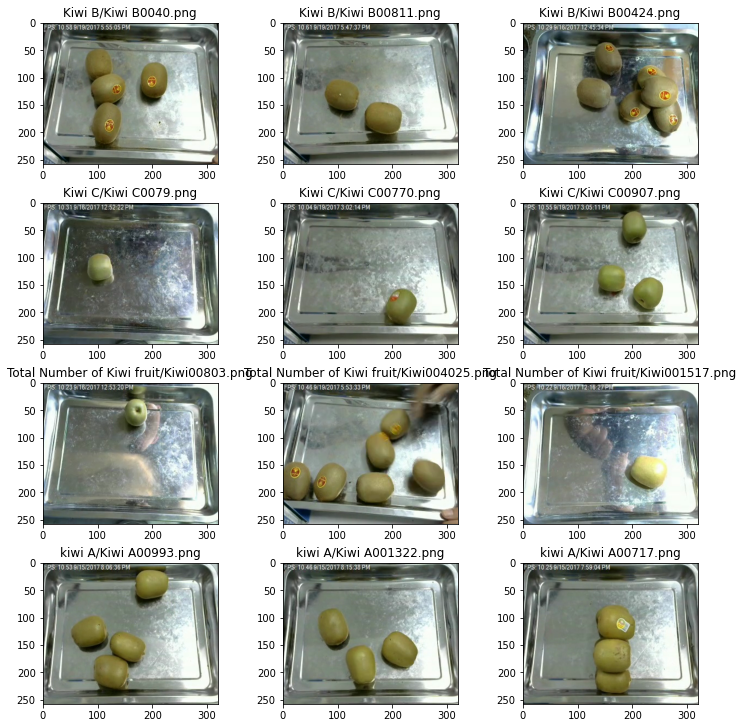

In [18]:
imshow_kind(data=df_a, kind='Kiwi')

IMPORTANT
- Do not use folder 'Total Number of Kiwi fruit'

  The folder contains multiple sub-categories of Kiwi.

In [19]:
# drop kind 'Total Number of Kiwi fruit'
def isolate():
    indicies = df_a[df_a['kind'] == 'Total Number of Kiwi fruit'].index
    df_a.drop(index=indicies, inplace=True)
    
isolate()

## Class Proportion

<AxesSubplot:xlabel='kind', ylabel='count'>

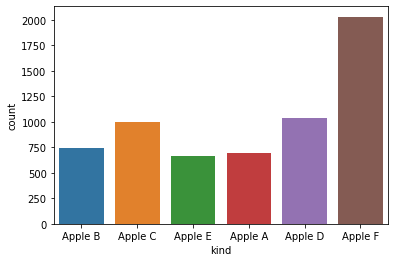

In [20]:
# Check histogram of Apple
sns.countplot(data=df_a[df_a['kind'].str.contains('Apple', case=False)], x='kind')

<AxesSubplot:xlabel='kind', ylabel='count'>

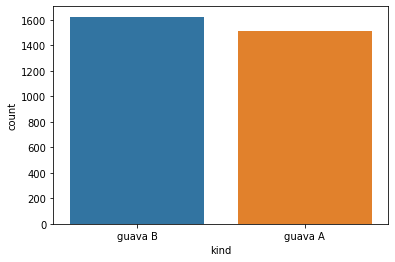

In [21]:
# Check histogram of Guava
sns.countplot(data=df_a[df_a['kind'].str.contains('Guava', case=False)], x='kind')

<AxesSubplot:xlabel='kind', ylabel='count'>

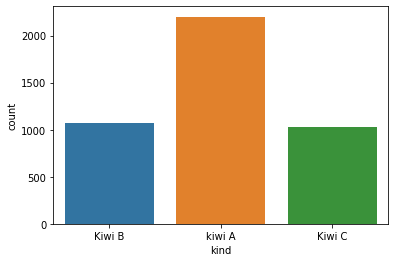

In [22]:
# Check histogram of Kiwi
sns.countplot(data=df_a[df_a['kind'].str.contains('Kiwi', case=False)], x='kind')

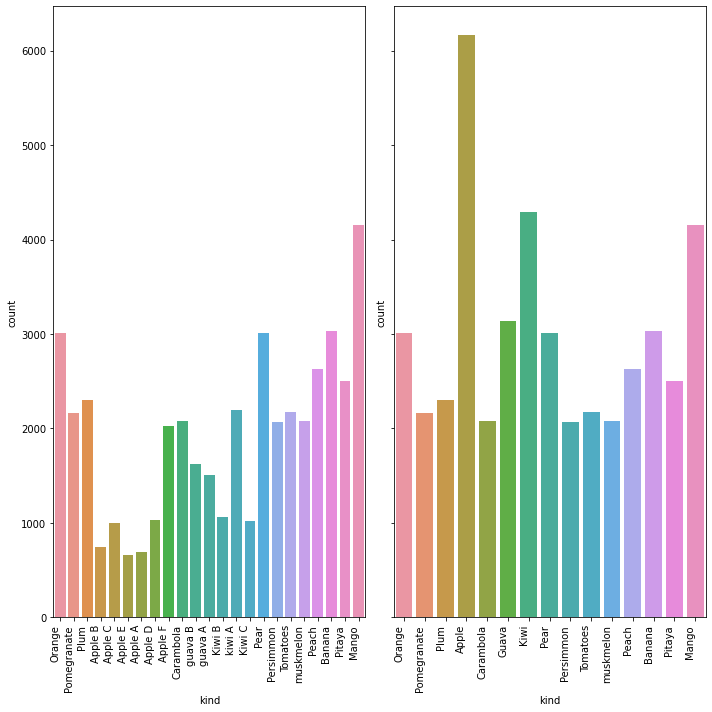

In [23]:
# Check histogram of kinds with sub-categories and without sub-categories
def isolate():    
    fig, axes = plt.subplots(1,2, figsize=(10,10), sharey=True)
    
    sns.countplot(data=df_a, x='kind', ax=axes[0])
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, ha='right')
    plt.tight_layout()
    
    df_c = df_a.copy()
    
    df_c.loc[df_c['kind'].str.contains("Apple", case=False), 'kind'] = 'Apple'
    df_c.loc[df_c['kind'].str.contains('Guava', case=False), 'kind'] = 'Guava'
    df_c.loc[df_c['kind'].str.contains('Kiwi', case=False), 'kind'] = 'Kiwi'
    
    sns.countplot(data=df_c, x='kind')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, ha='right')
    plt.tight_layout()
    
isolate()

UNCERTAIN

- Our understanding of how Convolutional Neural Networks works is by filtering pixels with a kernel. 

  The kernel does 3 things:
  1. Make the pixels smaller while also make sure that the model can still classify the image if the image was to be shifted or rotated.
  2. Help the model to classify image based on correlation (because the kernel makes a feature map and each cell in the feature map corresponds to a group of neighboring pixels)

We are not sure whether imbalanced data set will makes the model less sensitive to the class minority.

Few things to be sure:
1. we believe each Apple's sub category should have its own label as it is common for different kind of Apple to have different price in a grocery store.
2. Imbalanced data affects the ANN. By a glance, CNN should be affected by imbalanced data as well as it uses the same concept of weight, bias, optimizer, kernel initializer.

TODO
- [ ] Balanced the data set with under sampling.

      Get Apple E value_counts(), we will do this split strategy:
      1. data set  -> train_val 0.8 + test 0.2
      2. train_val -> train 0.8 + val 0.2
      
      therefore the data set proportion are: train 0.64 + val 0.16 + test 0.2

In [24]:
# Get Apple E value_counts()
df_a.loc[df_a['kind'] == 'Apple E', 'kind'].value_counts()

Apple E    664
Name: kind, dtype: int64

In [25]:
# Balancing data set with under sampling
df_b = df_a.copy()
# shuffle it
df_b = df_b.sample(frac=1, random_state=0)
df_b = df_b.groupby(by='kind').sample(n=160, random_state=0)
df_b['kind'] = df_b['kind'].astype('category')

In [26]:
# Sanity check
df_b['kind'].cat.categories

Index(['Apple A', 'Apple B', 'Apple C', 'Apple D', 'Apple E', 'Apple F',
       'Banana', 'Carambola', 'Kiwi B', 'Kiwi C', 'Mango', 'Orange', 'Peach',
       'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Tomatoes',
       'guava A', 'guava B', 'kiwi A', 'muskmelon'],
      dtype='object')

## Rescaling Effect

According to kode.id, [0-255] range is not ideal for neural network. Therefore, we are going to rescale it to [0-1] range

2022-12-11 09:25:38.734682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 09:25:38.829021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 09:25:38.829828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 09:25:38.832616: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Original tf.Tensor([102 109 109], shape=(3,), dtype=uint8)
Rescaled tf.Tensor([0.40000004 0.427451   0.427451  ], shape=(3,), dtype=float32)


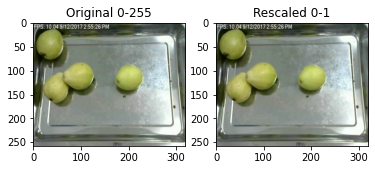

In [27]:
# See rescaling effect
def isolate():
    raw = tf.io.read_file(df_b.sample(n=1).iloc[0]['path'])
    img = tf.image.decode_png(raw, channels=3)
    
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(img)
    axes[0].set_title('Original 0-255')
    
    rescale = tf.keras.layers.Rescaling(1./255)
    axes[1].imshow(rescale(img))
    axes[1].set_title('Rescaled 0-1')
    
    print('Original', img[0,0])
    print('Rescaled', rescale(img)[0,0])
    
isolate()

Rescaling does not change the visiual.

## Resize Effect

The image should had resolution of 320x258 pixels. However, we found some images with 480x322 pixels. The model expects a fixed `input_shape`. Therefore, we will resize it

Cleanup called...
Cleanup called...


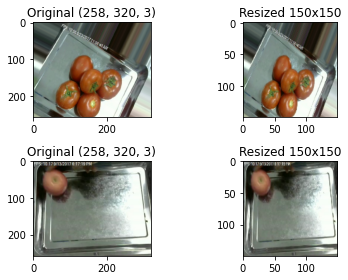

In [28]:
# visualize resize effect
def isolate():
    fig, axes = plt.subplots(2,2)
    
    ##########
    
    raw = tf.io.read_file(df_b.sample(n=1).iloc[0]['path'])
    img = tf.image.decode_png(raw, channels=3)
    
    axes[0][0].imshow(img)
    axes[0][0].set_title(f'Original {img.shape}')
    
    resize_and_rescale = tf.keras.Sequential([
        tf.keras.layers.Resizing(150,150),
        # Resizing output is float.
        # imshow float range is [0-1]
        tf.keras.layers.Rescaling(1./255)
    ])
    
    axes[0][1].imshow(resize_and_rescale(img))
    axes[0][1].set_title('Resized 150x150')
    
    ##########
    
    raw = tf.io.read_file(df_b.iloc[0]['path'])
    img = tf.image.decode_png(raw, channels=3)
    
    axes[1][0].imshow(img)
    axes[1][0].set_title(f'Original {img.shape}')
    
    axes[1][1].imshow(resize_and_rescale(img))
    axes[1][1].set_title('Resized 150x150')
    
    plt.tight_layout()
    
isolate()

## Data Augmentation Effect

Due to [the tensorflow 2.9, 2.10, 2.11 bug](https://stackoverflow.com/questions/73770146/warningtensorflowusing-a-while-loop-for-converting-cause-there-is-no-registere) and we can't downgrade to tensorflow 2.8 because that version only available on MacOS 11, we will not use `tf.keras.layers.RandomBrightness`. In the future, to simulate the real world and to cut cost and time for getting the data, we will use RandomBrightness, RandomRotation.

1. `RandomFlip(mode='horizontal_and_vertical')` can create 3 different images (horizontal, vertical, horizontal-vertical) from 1 image.
2. `RandomRotation(factor=0.2)` can create many different images by rotating the image in the range [-20%  2pi, 20% * 2pi]
3. and so on.

Cleanup called...


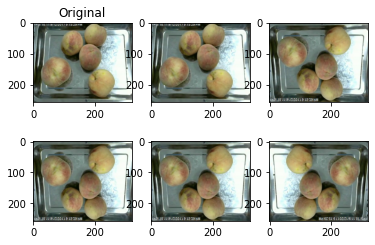

In [29]:
def isolate():
    raw = tf.io.read_file(df_b.sample(n=1).iloc[0]['path'])
    img = tf.image.decode_png(raw, channels=3)
    
    # expand_dims axis=0 1[ 2[ 3[]]] -> 1[ 2[ 3[ 4[]]]]
    # cast dtype=float32 [1] -> [1.0]
    # tp plot the image -> plt.imshow(img[0])
    # img = tf.expand_dims(img, 0)
    
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.Rescaling(scale=1./255),
        tf.keras.layers.RandomFlip(mode="horizontal_and_vertical")
    ])

    fig, axes = plt.subplots(2,3)
    
    axes[0][0].imshow(img)
    axes[0][0].set_title('Original')
    
    for ax in axes.ravel()[1:]:
        ax.imshow(data_augmentation(img))
    
isolate()

The RandomFlip helps us solve a problem:
1. The user use the camera upside down or from the wrong angle.

# Data Preprocessing

In [30]:
# Split data set to train, val, test
# Keras have validation_split parameter which makes spliting the data set convenient
# Although Keras told us it will select the last % percentage as test set 
# (meaning we know which data that will be used as the validation set)
# However, we can't stratify it.
df_train_val, df_test = train_test_split(df_b, test_size=0.2, random_state=0, stratify=df_b['kind'])
df_train, df_val = train_test_split(df_train_val, test_size=0.2, random_state=0, stratify=df_train_val['kind'])

In [31]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(150,150),
    tf.keras.layers.Rescaling(1./255)
])

In [32]:
def load_images(df):
    paths = df['path'].values
    X = []
    
    for path in paths:
        raw = tf.io.read_file(path)
        img = tf.image.decode_png(raw, channels=3)
        img = resize_and_rescale(img)
        X.append(img)
        
    y = df['kind'].cat.codes
    
    return np.array(X), tf.keras.utils.to_categorical(y)

In [33]:
# Load train set images
X_train, y_train = load_images(df_train)

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

[0.39425883 0.4356706  0.41435295]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


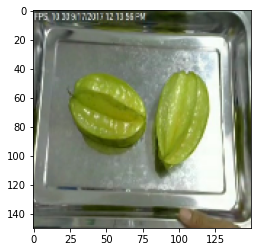

In [34]:
# Sanity check
print(X_train[0][0,0])
print(y_train[0])
plt.imshow(X_train[0])

In [35]:
# prefect
# reference: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch
# This allows later elements to be prepared while the current element is being processed.
# This oftens improves latency and throughput, at the cost of using additional memory to
# store prefetched elements.
train_pipe = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
                            .batch(256) \
                            .prefetch(buffer_size=tf.data.AUTOTUNE)

In [36]:
# Load val set images
X_val, y_val = load_images(df_val)

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

[0.3810144  0.40454382 0.40030852]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


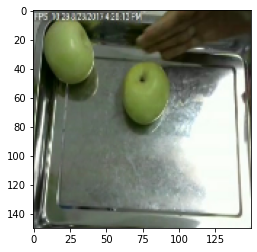

In [37]:
# Sanity check
print(X_val[0][0,0])
print(y_val[0])
plt.imshow(X_val[0])

In [38]:
val_pipe = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
                          .batch(256)

In [39]:
# Load test set images
# X_test, y_test = load_images(df_test)

ASK INSTRUCTOR

- [ ] Does stratify helps in CNN?
- [ ] Does stratify cause bias?
      
      My assumption is:
      1. The model now expects the class weights to be equal. What if the entire test set does not have fruit 'Apple A'? Will the model tend to classify some images as 'Apple A'? Which resulted in mislabeling?

# Reusable variables

In [40]:
# Reusable variable
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

img_shape = (150, 150, 3)

# seq_1 Conv2D(filters=6) and Conv2D(filters=6)

assumption:
1. the filters parameter is arbitary. we will start from 6.

## Model Definition

[reference filters](https://datascience.stackexchange.com/questions/55545/in-cnn-why-do-we-increase-the-number-of-filters-in-deeper-convolution-layers-fo)

[reference edges in 3d shape](https://opjsrgh.in/Content/Worksheet/PRACTICE-WS/day93/3-MATHS.pdf)

[reference CNN fruits](https://www.semanticscholar.org/paper/Convolutional-Neural-Networks-(CNN)-for-Detecting-Risdin-Mondal/8352826ff8f12ded684bf07540341a5ef6da06fd)

In [41]:
# seq_1 model definition
callbacks = [
    # Stop training when a monitored metric has stopped improving
    EarlyStopping(
        monitor='val_loss', patience=20, min_delta=0.0001, mode='min', 
        restore_best_weights=True),
    # Reduce learning rate when a metric has stopped improving.
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, 
        # We believe ReduceLROnPlateau should have less patience than EarlyStopping
        patience=10, min_delta=0.0001, min_lr=0.001),
    # Callback that streams epoch results to a CSV file
    CSVLogger(filename=f'{master_result}/seq_1.log'),
    # Callback to save the Keras model or model weights at some frequency.
    ModelCheckpoint(filepath=f'{master_result}/seq_1.h5', monitor='val_loss', save_best_only=True)
]

seq_1 = tf.keras.Sequential([
    # TODO: preprocessing layers in the model
    # standardize images.
    # resize_and_rescale,
    
    # Data augmentation is inactive at test time so input images will only be
    # augmented during calls to seq_1.fit
    data_augmentation,

    # we are not sure how more filters are necessary to classify image
    # but our philosophy are these:
    # 1. first layer extract features (edges, noise, etc) from raw image, 
    # which is noisy (a image contain object that is not relevant)
    # 2. second layer combine features (some edges) to get a shape e.g circle
    # 3. we believe 2 layers are enough to create features.
    Conv2D(
        input_shape=img_shape,
        # strides=1, so it overlap itself and takes advantage of correlation
        # to create a shape.
        # padding='same', so we don't lose information when the filter calculates the feature map
        filters=6, padding='same', kernel_size=(3,3), strides=(1,1),
        # feature map = filter + bias
        use_bias=True,
        # feature map + relu
        activation='relu'),
    # pool_size=(2,2), strides=2, 
    # so it does not overlap itself.
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    # we want smaller file size
    Conv2D(
        input_shape=img_shape,
        filters=6, padding='same', kernel_size=(3,3), strides=(1,1),
        use_bias=True,
        activation='relu'),
    MaxPooling2D(pool_size=(37,37), strides=(37,37)),
    
    Flatten(),
    
    Dense(units=24, activation='relu'),
    Dropout(rate=0.5),
    
    # softmax makes it easier to interpret (if we use threshold tuning)
    # we will use argmax in Model.compile().
    # but, argmax can't be used for backpropagation because the derivative is 0
    Dense(units=len(df_b['kind'].unique()), activation='softmax'),
])

seq_1.build(input_shape=(None, 150, 150, 3))

seq_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 6)       168       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 6)         330       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 6)           0         
_________________________________________________________________
flatten (Flatten)            (None, 24)                0         
_________________________________________________________________
dense (Dense)                (None, 24)               

In [42]:
seq_1.compile(
    optimizer='adam',
    # TODO: error if we use the function instance instead of the function name
    # loss=tf.keras.losses.CategoricalCrossentropy()
    # metrics=[tf.keras.metrics.CategoricalAccuracy()]
    
    # we use categorical_accuracy because the other alternative, accuracy
    # calculates the score by summed up the correct elements, then divided the total elements
    # while categorical accuracy uses np.argmax
    # therefore, we actually comparing np.argmax(y_true) with np.argmax(y_pred)
    # so, if the index does not match, it will not be counted as correct elements.
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

## Model Training

In [43]:
hist_seq_1 = seq_1.fit(train_pipe, 
                       epochs=100, callbacks=callbacks,
                       validation_data=val_pipe)

Epoch 1/100


2022-12-11 09:26:22.561909: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-11 09:26:23.608460: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


10/10 [==============================] - 11s 363ms/step - loss: 3.2348 - categorical_accuracy: 0.0437 - val_loss: 3.1467 - val_categorical_accuracy: 0.0467
Epoch 2/100
10/10 [==============================] - 3s 317ms/step - loss: 3.1444 - categorical_accuracy: 0.0459 - val_loss: 3.1392 - val_categorical_accuracy: 0.0433
Epoch 3/100
10/10 [==============================] - 3s 344ms/step - loss: 3.1418 - categorical_accuracy: 0.0408 - val_loss: 3.1359 - val_categorical_accuracy: 0.0391
Epoch 4/100
10/10 [==============================] - 3s 314ms/step - loss: 3.1351 - categorical_accuracy: 0.0450 - val_loss: 3.1335 - val_categorical_accuracy: 0.0361
Epoch 5/100
10/10 [==============================] - 3s 339ms/step - loss: 3.1332 - categorical_accuracy: 0.0454 - val_loss: 3.1316 - val_categorical_accuracy: 0.0437
Epoch 6/100
10/10 [==============================] - 3s 328ms/step - loss: 3.1339 - categorical_accuracy: 0.0488 - val_loss: 3.1303 - val_categorical_accuracy: 0.0514
Epoch 7/1

## Model Evaluation

epochs 99
categorical_accuracy 0.21
val_categorical_accuracy 0.25
loss 2.34
val_loss 2.19


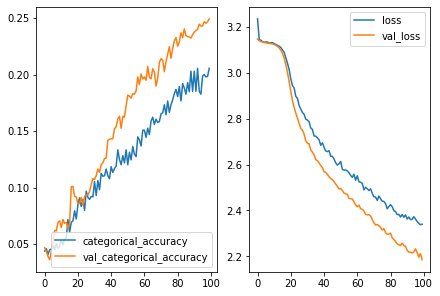

In [71]:
hist_seq_1_df = pd.DataFrame(hist_seq_1.history)

seq_1_best_epochs = np.argmin(hist_seq_1_df['val_loss'])
print("epochs %d" % (seq_1_best_epochs))
print("categorical_accuracy %.2f" % 
      (hist_seq_1_df.iloc[seq_1_best_epochs]['categorical_accuracy']))
print("val_categorical_accuracy %.2f" % 
      (hist_seq_1_df.iloc[seq_1_best_epochs]['val_categorical_accuracy']))
print("loss %.2f" %
      ((hist_seq_1_df.iloc[seq_1_best_epochs]['loss'])))
print("val_loss %.2f" % 
      (hist_seq_1_df.iloc[seq_1_best_epochs]['val_loss']))

def isolate():
    fig, axes = plt.subplots(1,2, layout="constrained")

    hist_seq_1_df[['categorical_accuracy', 'val_categorical_accuracy']].plot(ax=axes[0])
    hist_seq_1_df[['loss', 'val_loss']].plot(ax=axes[1])
    
isolate()

- the val_categorical_accuracy value is not acceptable.

  We believe the problem is because the number of features map are too few.
  
- The model is overfitted.

  Dropout(rate=0.5) does not help to regularize the network.

- The val_categorical_accuracy is higher than categorical_accuracy.

  This happened because of the train/val split percentage (train 0.64 + val 0.16 + test 0.2).

# seq_2 Conv2D(filters=23) and Conv2D(filters=23)

## Model Defnition

In [45]:
# seq_2 model definition
callbacks = [
    # Stop training when a monitored metric has stopped improving
    EarlyStopping(
        monitor='val_loss', patience=20, min_delta=0.0001, mode='min', 
        restore_best_weights=True),
    # Reduce learning rate when a metric has stopped improving.
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, 
        # We believe ReduceLROnPlateau should have less patience than EarlyStopping
        patience=10, min_delta=0.0001, min_lr=0.001),
    # Callback that streams epoch results to a CSV file
    CSVLogger(filename=f'{master_result}/seq_2.log'),
    # Callback to save the Keras model or model weights at some frequency.
    ModelCheckpoint(filepath=f'{master_result}/seq_2.h5', monitor='val_loss', save_best_only=True)
]

seq_2 = tf.keras.Sequential([
    # TODO: preprocessing layers in the model
    # standardize images.
    # resize_and_rescale,
    
    # Data augmentation is inactive at test time so input images will only be
    # augmented during calls to seq_1.fit
    data_augmentation,

    # we are not sure how more filters are necessary to classify image
    # but our philosophy are these:
    # 1. first layer extract features (edges, noise, etc) from raw image, 
    # which is noisy (a image contain object that is not relevant)
    # 2. second layer combine features (some edges) to get a shape e.g circle
    # 3. we believe 2 layers are enough to create features.
    Conv2D(
        input_shape=img_shape,
        # strides=1, so it overlap itself and takes advantage of correlation
        # to create a shape.
        # padding='same', so we don't lose information when the filter calculates the feature map
        filters=23, padding='same', kernel_size=(3,3), strides=(1,1),
        # feature map = filter + bias
        use_bias=True,
        # feature map + relu
        activation='relu'),
    # pool_size=(2,2), strides=2, 
    # so it does not overlap itself.
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    # we want smaller file size
    Conv2D(
        input_shape=img_shape,
        filters=23, padding='same', kernel_size=(3,3), strides=(1,1),
        use_bias=True,
        activation='relu'),
    MaxPooling2D(pool_size=(37,37), strides=(37,37)),
    
    Flatten(),
    
    Dense(units=92, activation='relu'),
    Dropout(rate=0.5),
    
    # softmax makes it easier to interpret (if we use threshold tuning)
    # we will use argmax in Model.compile().
    # but, argmax can't be used for backpropagation because the derivative is 0
    Dense(units=len(df_b['kind'].unique()), activation='softmax')
])

seq_2.build(input_shape=(None, 150, 150, 3))

seq_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 23)      644       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 23)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 23)        4784      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 23)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 92)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 92)               

In [46]:
seq_2.compile(
    optimizer='adam',
    # TODO: error if we use the function instance instead of the function name
    # loss=tf.keras.losses.CategoricalCrossentropy()
    # metrics=[tf.keras.metrics.CategoricalAccuracy()]
    
    # we use categorical_accuracy because the other alternative, accuracy
    # calculates the score by summed up the correct elements, then divided the total elements
    # while categorical accuracy uses np.argmax
    # therefore, we actually comparing np.argmax(y_true) with np.argmax(y_pred)
    # so, if the index does not match, it will not be counted as correct elements.
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

## Model Training

In [47]:
hist_seq_2 = seq_2.fit(train_pipe, 
                       epochs=100, callbacks=callbacks,
                       validation_data=val_pipe)

Epoch 1/100
10/10 [==============================] - 5s 371ms/step - loss: 3.1650 - categorical_accuracy: 0.0539 - val_loss: 3.1331 - val_categorical_accuracy: 0.0497
Epoch 2/100
10/10 [==============================] - 3s 318ms/step - loss: 3.1325 - categorical_accuracy: 0.0539 - val_loss: 3.1251 - val_categorical_accuracy: 0.0692
Epoch 3/100
10/10 [==============================] - 3s 316ms/step - loss: 3.1220 - categorical_accuracy: 0.0633 - val_loss: 3.1099 - val_categorical_accuracy: 0.0599
Epoch 4/100
10/10 [==============================] - 3s 342ms/step - loss: 3.1051 - categorical_accuracy: 0.0628 - val_loss: 3.0793 - val_categorical_accuracy: 0.0493
Epoch 5/100
10/10 [==============================] - 3s 362ms/step - loss: 3.0687 - categorical_accuracy: 0.0747 - val_loss: 3.0214 - val_categorical_accuracy: 0.0565
Epoch 6/100
10/10 [==============================] - 3s 325ms/step - loss: 3.0008 - categorical_accuracy: 0.0730 - val_loss: 2.9194 - val_categorical_accuracy: 0.110

## Model Evaluation

epochs 99
categorical_accuracy 0.78
val_categorical_accuracy 0.85
loss 0.64
val_loss 0.45


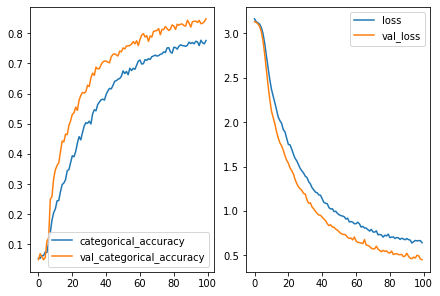

In [70]:
hist_seq_2_df = pd.DataFrame(hist_seq_2.history)

seq_2_best_epochs = np.argmin(hist_seq_2_df['val_loss'])
print("epochs %d" % (seq_2_best_epochs))
print("categorical_accuracy %.2f" % 
      (hist_seq_2_df.iloc[seq_2_best_epochs]['categorical_accuracy']))
print("val_categorical_accuracy %.2f" % 
      (hist_seq_2_df.iloc[seq_2_best_epochs]['val_categorical_accuracy']))
print("loss %.2f" %
      ((hist_seq_2_df.iloc[seq_2_best_epochs]['loss'])))
print("val_loss %.2f" % 
      (hist_seq_2_df.iloc[seq_2_best_epochs]['val_loss']))

def isolate():
    fig, axes = plt.subplots(1,2, layout="constrained")

    hist_seq_2_df[['categorical_accuracy', 'val_categorical_accuracy']].plot(ax=axes[0])
    hist_seq_2_df[['loss', 'val_loss']].plot(ax=axes[1])
    
isolate()

- The val_categorical_accuracy increased.
- The model is still overfitted.

# seq_3 Conv2D(filters=32) and Conv2D(filters=32)

## Model Definition

In [49]:
# seq_3 model definition
callbacks = [
    # Stop training when a monitored metric has stopped improving
    EarlyStopping(
        monitor='val_loss', patience=20, min_delta=0.0001, mode='min', 
        restore_best_weights=True),
    # Reduce learning rate when a metric has stopped improving.
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, 
        # We believe ReduceLROnPlateau should have less patience than EarlyStopping
        patience=10, min_delta=0.0001, min_lr=0.001),
    # Callback that streams epoch results to a CSV file
    CSVLogger(filename=f'{master_result}/seq_3.log'),
    # Callback to save the Keras model or model weights at some frequency.
    ModelCheckpoint(filepath=f'{master_result}/seq_3.h5', monitor='val_loss', save_best_only=True)
]

seq_3 = tf.keras.Sequential([
    # TODO: preprocessing layers in the model
    # standardize images.
    # resize_and_rescale,
    
    # Data augmentation is inactive at test time so input images will only be
    # augmented during calls to seq_1.fit
    data_augmentation,

    # we are not sure how more filters are necessary to classify image
    # but our philosophy are these:
    # 1. first layer extract features (edges, noise, etc) from raw image, 
    # which is noisy (a image contain object that is not relevant)
    # 2. second layer combine features (some edges) to get a shape e.g circle
    # 3. we believe 2 layers are enough to create features.
    Conv2D(
        input_shape=img_shape,
        # strides=1, so it overlap itself and takes advantage of correlation
        # to create a shape.
        # padding='same', so we don't lose information when the filter calculates the feature map
        filters=32, padding='same', kernel_size=(3,3), strides=(1,1),
        # feature map = filter + bias
        use_bias=True,
        # feature map + relu
        activation='relu'),
    # pool_size=(2,2), strides=2, 
    # so it does not overlap itself.
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    # we want smaller file size
    Conv2D(
        input_shape=img_shape,
        filters=32, padding='same', kernel_size=(3,3), strides=(1,1),
        use_bias=True,
        activation='relu'),
    MaxPooling2D(pool_size=(37,37), strides=(37,37)),
    
    Flatten(),
    
    Dense(units=128, activation='relu'),
    Dropout(rate=0.5),
    
    # softmax makes it easier to interpret (if we use threshold tuning)
    # we will use argmax in Model.compile().
    # but, argmax can't be used for backpropagation because the derivative is 0
    Dense(units=len(df_b['kind'].unique()), activation='softmax')
])

seq_3.build(input_shape=(None, 150, 150, 3))

seq_3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [50]:
seq_3.compile(
    optimizer='adam',
    # TODO: error if we use the function instance instead of the function name
    # loss=tf.keras.losses.CategoricalCrossentropy()
    # metrics=[tf.keras.metrics.CategoricalAccuracy()]
    
    # we use categorical_accuracy because the other alternative, accuracy
    # calculates the score by summed up the correct elements, then divided the total elements
    # while categorical accuracy uses np.argmax
    # therefore, we actually comparing np.argmax(y_true) with np.argmax(y_pred)
    # so, if the index does not match, it will not be counted as correct elements.
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

## Model Training

In [51]:
hist_seq_3 = seq_3.fit(train_pipe, 
                       epochs=100, callbacks=callbacks,
                       validation_data=val_pipe)

Epoch 1/100
10/10 [==============================] - 5s 370ms/step - loss: 3.1522 - categorical_accuracy: 0.0446 - val_loss: 3.1146 - val_categorical_accuracy: 0.0480
Epoch 2/100
10/10 [==============================] - 3s 366ms/step - loss: 3.1060 - categorical_accuracy: 0.0624 - val_loss: 3.0748 - val_categorical_accuracy: 0.0803
Epoch 3/100
10/10 [==============================] - 3s 330ms/step - loss: 3.0510 - categorical_accuracy: 0.0837 - val_loss: 2.9775 - val_categorical_accuracy: 0.1244
Epoch 4/100
10/10 [==============================] - 3s 347ms/step - loss: 2.9363 - categorical_accuracy: 0.1193 - val_loss: 2.8062 - val_categorical_accuracy: 0.1270
Epoch 5/100
10/10 [==============================] - 3s 330ms/step - loss: 2.7846 - categorical_accuracy: 0.1308 - val_loss: 2.6033 - val_categorical_accuracy: 0.1826
Epoch 6/100
10/10 [==============================] - 3s 363ms/step - loss: 2.6020 - categorical_accuracy: 0.1682 - val_loss: 2.4049 - val_categorical_accuracy: 0.278

## Model Evaluation

epochs 99
categorical_accuracy 0.81
val_categorical_accuracy 0.87
loss 0.55
val_loss 0.38


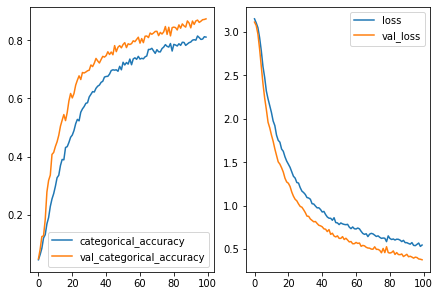

In [69]:
hist_seq_3_df = pd.DataFrame(hist_seq_3.history)

seq_3_best_epochs = np.argmin(hist_seq_3_df['val_loss'])
print("epochs %d" % (seq_3_best_epochs))
print("categorical_accuracy %.2f" % 
      (hist_seq_3_df.iloc[seq_3_best_epochs]['categorical_accuracy']))
print("val_categorical_accuracy %.2f" % 
      (hist_seq_3_df.iloc[seq_3_best_epochs]['val_categorical_accuracy']))
print("loss %.2f" %
      ((hist_seq_3_df.iloc[seq_3_best_epochs]['loss'])))
print("val_loss %.2f" % 
      (hist_seq_3_df.iloc[seq_3_best_epochs]['val_loss']))

def isolate():
    fig, axes = plt.subplots(1,2, layout="constrained")

    hist_seq_3_df[['categorical_accuracy', 'val_categorical_accuracy']].plot(ax=axes[0])
    hist_seq_3_df[['loss', 'val_loss']].plot(ax=axes[1])
    
isolate()

- The val_categorical_accuracy increased.
- The model is still overfitted.

# seq_4 Conv2D(filters=32) and Conv2D(filters=64)

## Model Definition

In [53]:
# seq_4 model definition
callbacks = [
    # Stop training when a monitored metric has stopped improving
    EarlyStopping(
        monitor='val_loss', patience=20, min_delta=0.0001, mode='min', 
        restore_best_weights=True),
    # Reduce learning rate when a metric has stopped improving.
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, 
        # We believe ReduceLROnPlateau should have less patience than EarlyStopping
        patience=10, min_delta=0.0001, min_lr=0.001),
    # Callback that streams epoch results to a CSV file
    CSVLogger(filename=f'{master_result}/seq_4.log'),
    # Callback to save the Keras model or model weights at some frequency.
    ModelCheckpoint(filepath=f'{master_result}/seq_4.h5', monitor='val_loss', save_best_only=True)
]

seq_4 = tf.keras.Sequential([
    # TODO: preprocessing layers in the model
    # standardize images.
    # resize_and_rescale,
    
    # Data augmentation is inactive at test time so input images will only be
    # augmented during calls to seq_1.fit
    data_augmentation,

    # we are not sure how more filters are necessary to classify image
    # but our philosophy are these:
    # 1. first layer extract features (edges, noise, etc) from raw image, 
    # which is noisy (a image contain object that is not relevant)
    # 2. second layer combine features (some edges) to get a shape e.g circle
    # 3. we believe 2 layers are enough to create features.
    Conv2D(
        input_shape=img_shape,
        # strides=1, so it overlap itself and takes advantage of correlation
        # to create a shape.
        # padding='same', so we don't lose information when the filter calculates the feature map
        filters=32, padding='same', kernel_size=(3,3), strides=(1,1),
        # feature map = filter + bias
        use_bias=True,
        # feature map + relu
        activation='relu'),
    # pool_size=(2,2), strides=2, 
    # so it does not overlap itself.
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    # we want smaller file size
    Conv2D(
        input_shape=img_shape,
        filters=64, padding='same', kernel_size=(3,3), strides=(1,1),
        use_bias=True,
        activation='relu'),
    MaxPooling2D(pool_size=(37,37), strides=(37,37)),
    
    Flatten(),
    
    Dense(units=256, activation='relu'),
    Dropout(rate=0.5),
    
    # softmax makes it easier to interpret (if we use threshold tuning)
    # we will use argmax in Model.compile().
    # but, argmax can't be used for backpropagation because the derivative is 0
    Dense(units=len(df_b['kind'].unique()), activation='softmax')
])

seq_4.build(input_shape=(None, 150, 150, 3))

seq_4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

In [54]:
seq_4.compile(
    optimizer='adam',
    # TODO: error if we use the function instance instead of the function name
    # loss=tf.keras.losses.CategoricalCrossentropy()
    # metrics=[tf.keras.metrics.CategoricalAccuracy()]
    
    # we use categorical_accuracy because the other alternative, accuracy
    # calculates the score by summed up the correct elements, then divided the total elements
    # while categorical accuracy uses np.argmax
    # therefore, we actually comparing np.argmax(y_true) with np.argmax(y_pred)
    # so, if the index does not match, it will not be counted as correct elements.
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

## Model Training

In [55]:
hist_seq_4 = seq_4.fit(train_pipe, 
                       epochs=100, callbacks=callbacks,
                       validation_data=val_pipe)

Epoch 1/100
10/10 [==============================] - 5s 417ms/step - loss: 3.1494 - categorical_accuracy: 0.0374 - val_loss: 3.1320 - val_categorical_accuracy: 0.0518
Epoch 2/100
10/10 [==============================] - 4s 390ms/step - loss: 3.1254 - categorical_accuracy: 0.0569 - val_loss: 3.1153 - val_categorical_accuracy: 0.0764
Epoch 3/100
10/10 [==============================] - 4s 411ms/step - loss: 3.0966 - categorical_accuracy: 0.0671 - val_loss: 3.0575 - val_categorical_accuracy: 0.0611
Epoch 4/100
10/10 [==============================] - 4s 387ms/step - loss: 3.0111 - categorical_accuracy: 0.0896 - val_loss: 2.9067 - val_categorical_accuracy: 0.1452
Epoch 5/100
10/10 [==============================] - 4s 402ms/step - loss: 2.8637 - categorical_accuracy: 0.1134 - val_loss: 2.6921 - val_categorical_accuracy: 0.1970
Epoch 6/100
10/10 [==============================] - 4s 391ms/step - loss: 2.6747 - categorical_accuracy: 0.1380 - val_loss: 2.4768 - val_categorical_accuracy: 0.209

## Model Evaluation

epochs 98
categorical_accuracy 0.86
val_categorical_accuracy 0.91
loss 0.37
val_loss 0.27


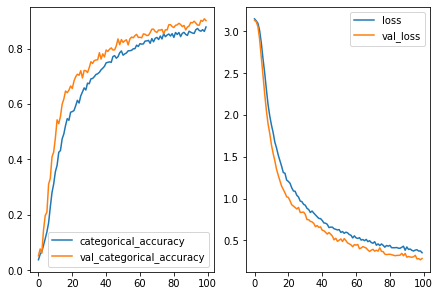

In [68]:
hist_seq_4_df = pd.DataFrame(hist_seq_4.history)

seq_4_best_epochs = np.argmin(hist_seq_4_df['val_loss'])
print("epochs %d" % (seq_4_best_epochs))
print("categorical_accuracy %.2f" % 
      (hist_seq_4_df.iloc[seq_4_best_epochs]['categorical_accuracy']))
print("val_categorical_accuracy %.2f" % 
      (hist_seq_4_df.iloc[seq_4_best_epochs]['val_categorical_accuracy']))
print("loss %.2f" %
      ((hist_seq_4_df.iloc[seq_4_best_epochs]['loss'])))
print("val_loss %.2f" % 
      (hist_seq_4_df.iloc[seq_4_best_epochs]['val_loss']))

def isolate():
    fig, axes = plt.subplots(1,2, layout="constrained")

    hist_seq_4_df[['categorical_accuracy', 'val_categorical_accuracy']].plot(ax=axes[0])
    hist_seq_4_df[['loss', 'val_loss']].plot(ax=axes[1])
    
isolate()

- The val_categorical_accuracy increased.
- The model is still overfitted.

# seq_5 step by step to decrease the ANN input

## Model Definition

In [57]:
# seq_5 model definition
callbacks = [
    # Stop training when a monitored metric has stopped improving
    EarlyStopping(
        monitor='val_loss', patience=20, min_delta=0.0001, mode='min', 
        restore_best_weights=True),
    # Reduce learning rate when a metric has stopped improving.
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, 
        # We believe ReduceLROnPlateau should have less patience than EarlyStopping
        patience=10, min_delta=0.0001, min_lr=0.001),
    # Callback that streams epoch results to a CSV file
    CSVLogger(filename=f'{master_result}/seq_5.log'),
    # Callback to save the Keras model or model weights at some frequency.
    ModelCheckpoint(filepath=f'{master_result}/seq_5.h5', monitor='val_loss', save_best_only=True)
]

seq_5 = tf.keras.Sequential([
    # TODO: preprocessing layers in the model
    # standardize images.
    # resize_and_rescale,
    
    # Data augmentation is inactive at test time so input images will only be
    # augmented during calls to seq_1.fit
    data_augmentation,

    # we are not sure how more filters are necessary to classify image
    # but our philosophy are these:
    # 1. first layer extract features (edges, noise, etc) from raw image, 
    # which is noisy (a image contain object that is not relevant)
    # 2. second layer combine features (some edges) to get a shape e.g circle
    # 3. we believe 2 layers are enough to create features.
    Conv2D(
        input_shape=img_shape,
        # strides=1, so it overlap itself and takes advantage of correlation
        # to create a shape.
        # padding='same', so we don't lose information when the filter calculates the feature map
        filters=32, padding='same', kernel_size=(3,3), strides=(1,1),
        # feature map = filter + bias
        use_bias=True,
        # feature map + relu
        activation='relu'),
    # pool_size=(2,2), strides=2, 
    # so it does not overlap itself.
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    # we want smaller file size
    Conv2D(
        input_shape=img_shape,
        filters=64, padding='same', kernel_size=(3,3), strides=(1,1),
        use_bias=True,
        activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    Conv2D(
        input_shape=img_shape,
        filters=64, padding='same', kernel_size=(3,3), strides=(1,1),
        use_bias=True,
        activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    Conv2D(
        input_shape=img_shape,
        filters=64, padding='same', kernel_size=(3,3), strides=(1,1),
        use_bias=True,
        activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    Conv2D(
        input_shape=img_shape,
        filters=64, padding='same', kernel_size=(3,3), strides=(1,1),
        use_bias=True,
        activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    Conv2D(
        input_shape=img_shape,
        filters=64, padding='same', kernel_size=(3,3), strides=(1,1),
        use_bias=True,
        activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    Flatten(),
    
    Dense(units=256, activation='relu'),
    Dropout(rate=0.5),
    
    # softmax makes it easier to interpret (if we use threshold tuning)
    # we will use argmax in Model.compile().
    # but, argmax can't be used for backpropagation because the derivative is 0
    Dense(units=len(df_b['kind'].unique()), activation='softmax')
])

seq_5.build(input_shape=(None, 150, 150, 3))

seq_5.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 18, 18, 64)       

In [58]:
seq_5.compile(
    optimizer='adam',
    # TODO: error if we use the function instance instead of the function name
    # loss=tf.keras.losses.CategoricalCrossentropy()
    # metrics=[tf.keras.metrics.CategoricalAccuracy()]
    
    # we use categorical_accuracy because the other alternative, accuracy
    # calculates the score by summed up the correct elements, then divided the total elements
    # while categorical accuracy uses np.argmax
    # therefore, we actually comparing np.argmax(y_true) with np.argmax(y_pred)
    # so, if the index does not match, it will not be counted as correct elements.
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

## Model Training

In [59]:
hist_seq_5 = seq_5.fit(train_pipe, 
                       epochs=100, callbacks=callbacks,
                       validation_data=val_pipe)

Epoch 1/100
10/10 [==============================] - 5s 380ms/step - loss: 3.1365 - categorical_accuracy: 0.0412 - val_loss: 3.1234 - val_categorical_accuracy: 0.0611
Epoch 2/100
10/10 [==============================] - 3s 350ms/step - loss: 3.0589 - categorical_accuracy: 0.0476 - val_loss: 2.9091 - val_categorical_accuracy: 0.0998
Epoch 3/100
10/10 [==============================] - 3s 352ms/step - loss: 2.9149 - categorical_accuracy: 0.0837 - val_loss: 2.7879 - val_categorical_accuracy: 0.1134
Epoch 4/100
10/10 [==============================] - 3s 354ms/step - loss: 2.7660 - categorical_accuracy: 0.0994 - val_loss: 2.6055 - val_categorical_accuracy: 0.1486
Epoch 5/100
10/10 [==============================] - 3s 351ms/step - loss: 2.6299 - categorical_accuracy: 0.1270 - val_loss: 2.4039 - val_categorical_accuracy: 0.1868
Epoch 6/100
10/10 [==============================] - 3s 353ms/step - loss: 2.3964 - categorical_accuracy: 0.1766 - val_loss: 2.1671 - val_categorical_accuracy: 0.242

## Model Evaluation

epochs 96
categorical_accuracy 0.90
val_categorical_accuracy 0.93
loss 0.26
val_loss 0.18


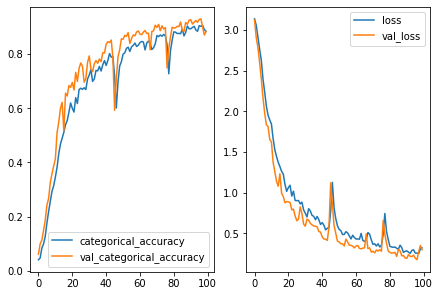

In [67]:
hist_seq_5_df = pd.DataFrame(hist_seq_5.history)

seq_5_best_epochs = np.argmin(hist_seq_5_df['val_loss'])
print("epochs %d" % (seq_5_best_epochs))
print("categorical_accuracy %.2f" % 
      (hist_seq_5_df.iloc[seq_5_best_epochs]['categorical_accuracy']))
print("val_categorical_accuracy %.2f" % 
      (hist_seq_5_df.iloc[seq_5_best_epochs]['val_categorical_accuracy']))
print("loss %.2f" %
      ((hist_seq_5_df.iloc[seq_5_best_epochs]['loss'])))
print("val_loss %.2f" % 
      (hist_seq_5_df.iloc[seq_5_best_epochs]['val_loss']))

def isolate():
    fig, axes = plt.subplots(1,2, layout="constrained")

    hist_seq_5_df[['categorical_accuracy', 'val_categorical_accuracy']].plot(ax=axes[0])
    hist_seq_5_df[['loss', 'val_loss']].plot(ax=axes[1])
    
isolate()

- The val_categorical_accuracy increased.
- The model is still overfitted.